# An example of tracking sensory input and action commands during episode rollout

During episode rollout, it's trivial to access and record any quantity involved in the MuJoCo physics simulation, whether this quantity is part of the model observables or not.

# Imports

In [ ]:
import os
import requests
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import PIL.ImageDraw
import mediapy
from tqdm import tqdm

import tensorflow as tf
import tensorflow_probability as tfp
from acme import wrappers

from flybody.fly_envs import flight_imitation
from flybody.agents.utils_tf import TestPolicyWrapper

In [ ]:
# Prevent tensorflow from stealing all the gpu memory.
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

render_kwargs = {'width': 640, 'height': 480}

# Download example data from `figshare`

__Caution__: this cell will create a `flybody-data` directory and download ~3GB of data into it. You may want to delete the downloaded files when you're finished with the notebook.

In [7]:
url_policy = 'https://janelia.figshare.com/ndownloader/files/44815195'
url_data = 'https://janelia.figshare.com/ndownloader/files/44869654'

base_path = 'flybody-data'
os.makedirs(base_path, exist_ok=True)

# Download and unzip policies.
path_policies = os.path.join(base_path, 'policies.zip')
response = requests.get(url_policy)
response.raise_for_status()
with open(path_policies, 'wb') as f:
    f.write(response.content)
with zipfile.ZipFile(path_policies, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if file.startswith('flight/'):
            zip_ref.extract(member=file, path=base_path)

# Donwload and unzip flight trajectories and WPG.
path_data = os.path.join(base_path, 'data.zip')
response = requests.get(url_data)
response.raise_for_status()
with open(path_data, 'wb') as f:
    f.write(response.content)
with zipfile.ZipFile(path_data, 'r') as zip_ref:
    zip_ref.extract(member='flight-dataset_saccade-evasion_augmented.hdf5', path=base_path)
    zip_ref.extract(member='wing_pattern_fmech.npy', path=base_path)

# Create flight imitation task environment

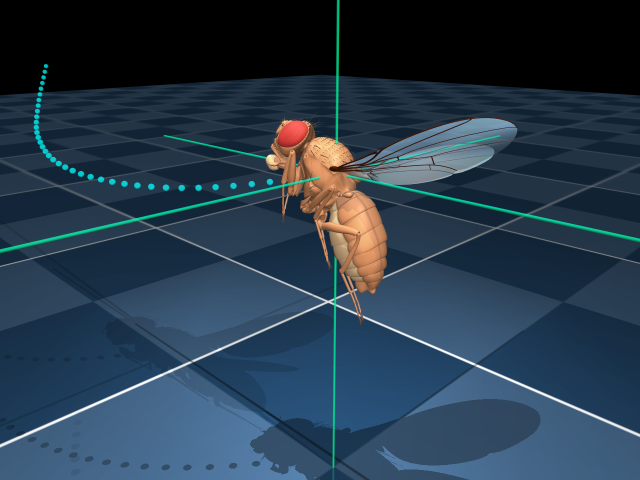

In [8]:
wpg_path = os.path.join(base_path, 'wing_pattern_fmech.npy')
ref_flight_path = os.path.join(base_path, 'flight-dataset_saccade-evasion_augmented.hdf5')

env = flight_imitation(
    ref_path=ref_flight_path,
    wpg_pattern_path=wpg_path,
    terminal_com_dist=float('inf'),
)
env = wrappers.SinglePrecisionWrapper(env)
env = wrappers.CanonicalSpecWrapper(env, clip=True)

_ = env.reset()
pixels = env.physics.render(camera_id=1, **render_kwargs)
PIL.Image.fromarray(pixels)

In [9]:
env.observation_spec()

OrderedDict([('walker/accelerometer',
              Array(shape=(3,), dtype=dtype('float32'), name='walker/accelerometer')),
             ('walker/actuator_activation',
              Array(shape=(0,), dtype=dtype('float32'), name='walker/actuator_activation')),
             ('walker/gyro',
              Array(shape=(3,), dtype=dtype('float32'), name='walker/gyro')),
             ('walker/joints_pos',
              Array(shape=(25,), dtype=dtype('float32'), name='walker/joints_pos')),
             ('walker/joints_vel',
              Array(shape=(25,), dtype=dtype('float32'), name='walker/joints_vel')),
             ('walker/velocimeter',
              Array(shape=(3,), dtype=dtype('float32'), name='walker/velocimeter')),
             ('walker/world_zaxis',
              Array(shape=(3,), dtype=dtype('float32'), name='walker/world_zaxis')),
             ('walker/ref_displacement',
              Array(shape=(6, 3), dtype=dtype('float32'), name='walker/ref_displacement')),
             ('w

In [10]:
env.action_spec()

BoundedArray(shape=(12,), dtype=dtype('float32'), name='head_abduct\thead_twist\thead\twing_yaw_left\twing_roll_left\twing_pitch_left\twing_yaw_right\twing_roll_right\twing_pitch_right\tabdomen_abduct\tabdomen\tuser_0', minimum=[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], maximum=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.])

# Load a pre-trained flight policy

In [13]:
# Load flight policy.
policy = tf.saved_model.load(os.path.join(base_path, 'flight'))
policy = TestPolicyWrapper(policy)

# Rollout an episode and record:
1. Observable sensory inputs
2. Action commands
3. Unobserved quantities from physics simulator (fly body position and orientation)
4. (also record video)

In [ ]:
n_steps = 150

timestep = env.reset()

# Allocate.
joints_pos = np.zeros((n_steps, 25))  # Proprioception: observable joint angles.
vel = np.zeros((n_steps, 3))  # Velocimeter.
zaxis = np.zeros((n_steps, 3))  # Gravity direction.
root_qpos = np.zeros((n_steps, 7))  # Fly's position and orientation.
actions = np.zeros((n_steps, 6))  # Wing action commands.

frames = []

for i in tqdm(range(n_steps)):

    # Record some of the sensory inputs.
    joints_pos[i] = timestep.observation['walker/joints_pos']
    vel[i] = timestep.observation['walker/velocimeter']
    zaxis[i] = timestep.observation['walker/world_zaxis']
    root_qpos[i] = env.physics.data.qpos[:7].copy()
    
    frames.append(env.physics.render(camera_id=1, **render_kwargs))

    # Step simulation.
    action = policy(timestep.observation)
    timestep = env.step(action)

    # Record wing action commands.
    actions[i] = action[3:9]


## Show rollout video

In [ ]:
mediapy.show_video(frames)

In [26]:
# Print observable joint names and indices.
[(i, joint.name) for i, joint in enumerate(env.task.walker.observable_joints)]

[(0, 'head_abduct'),
 (1, 'head_twist'),
 (2, 'head'),
 (3, 'wing_yaw_left'),
 (4, 'wing_roll_left'),
 (5, 'wing_pitch_left'),
 (6, 'wing_yaw_right'),
 (7, 'wing_roll_right'),
 (8, 'wing_pitch_right'),
 (9, 'abdomen_abduct'),
 (10, 'abdomen'),
 (11, 'abdomen_abduct_2'),
 (12, 'abdomen_2'),
 (13, 'abdomen_abduct_3'),
 (14, 'abdomen_3'),
 (15, 'abdomen_abduct_4'),
 (16, 'abdomen_4'),
 (17, 'abdomen_abduct_5'),
 (18, 'abdomen_5'),
 (19, 'abdomen_abduct_6'),
 (20, 'abdomen_6'),
 (21, 'abdomen_abduct_7'),
 (22, 'abdomen_7'),
 (23, 'haltere_left'),
 (24, 'haltere_right')]

# Plot example sensory inputs from the rollout

### Proprioception sensory inputs: head, abdomen, wing joint angles

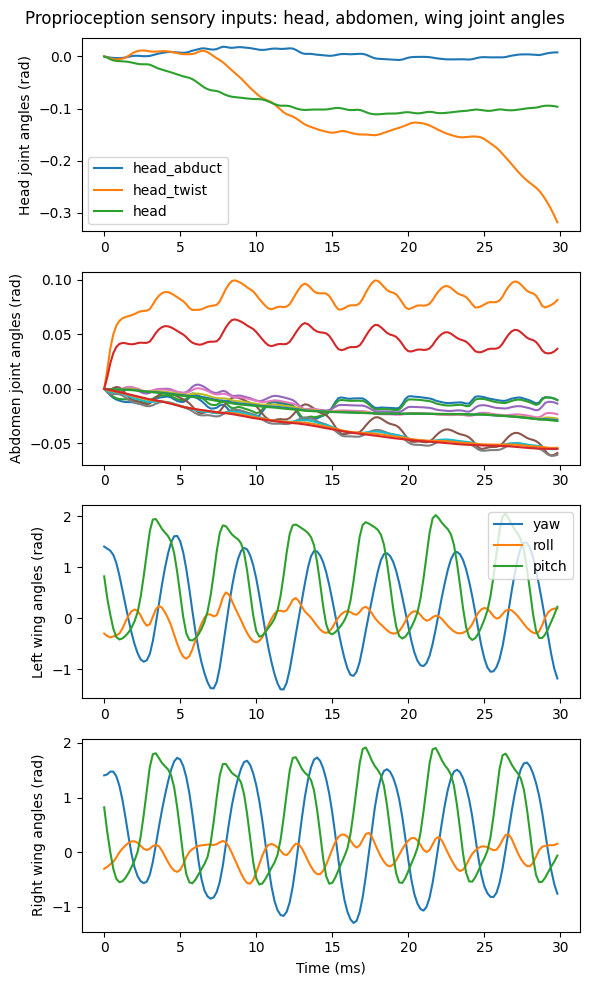

In [27]:
time_axis = np.arange(n_steps) * env.control_timestep() * 1000  # ms

plt.figure(figsize=(6, 10))
plt.suptitle('Proprioception sensory inputs: head, abdomen, wing joint angles')
plt.subplot(4, 1, 1)  # Head joints.
plt.plot(time_axis, joints_pos[:, :3], label=['head_abduct', 'head_twist', 'head'])
plt.ylabel('Head joint angles (rad)')
plt.legend()
plt.subplot(4, 1, 2)  # Abdomen joints.
plt.plot(time_axis, joints_pos[:, 9:23])
plt.ylabel('Abdomen joint angles (rad)')
plt.subplot(4, 1, 3)  # Left wing.
plt.plot(time_axis, joints_pos[:, 3:6], label=['yaw', 'roll', 'pitch'])
plt.ylabel('Left wing angles (rad)')
plt.legend()
plt.subplot(4, 1, 4)  # Right wing.
plt.plot(time_axis, joints_pos[:, 6:9])
plt.xlabel('Time (ms)')
plt.ylabel('Right wing angles (rad)')
plt.tight_layout()

### Egocentric velocity vector

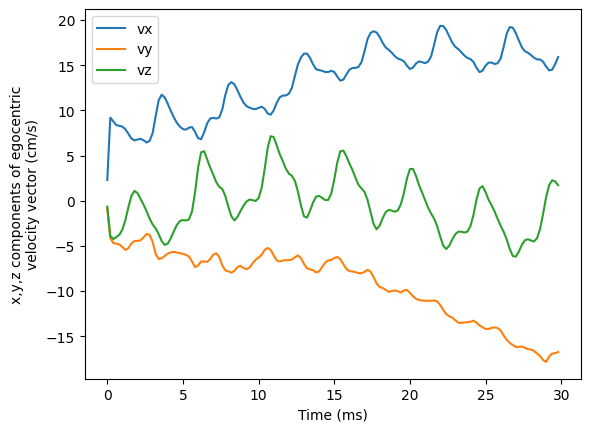

In [28]:
plt.plot(time_axis, vel, label=['vx', 'vy', 'vz'])
plt.xlabel('Time (ms)')
plt.ylabel('x,y,z components of egocentric\nvelocity vector (cm/s)')
plt.legend()

### Egocentric gravity direction vector

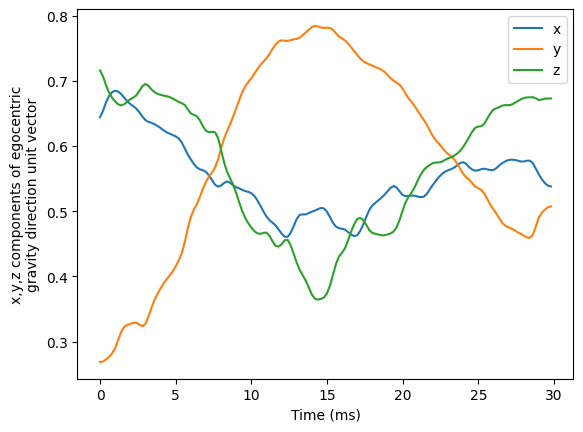

In [29]:
plt.plot(time_axis, zaxis, label=['x', 'y', 'z'])
plt.xlabel('Time (ms)')
plt.ylabel('x,y,z components of egocentric\ngravity direction unit vector')
plt.legend()

### Wing action commands

Text(0, 0.5, 'Right wing control')

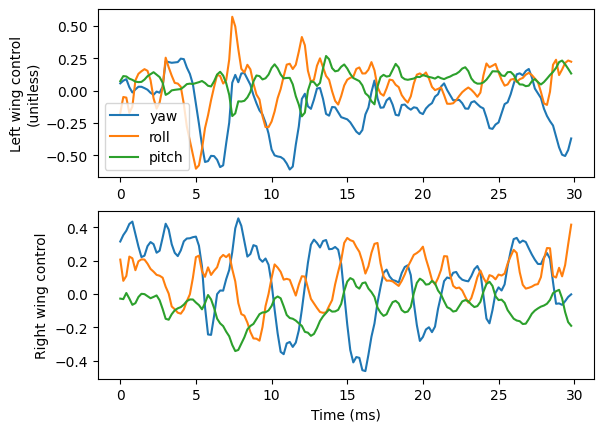

In [30]:
# Unitless, between (-1, 1).
plt.subplot(2, 1, 1)
plt.plot(time_axis, actions[:, :3], label=['yaw', 'roll', 'pitch'])
plt.ylabel('Left wing control\n(unitless)')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(time_axis, actions[:, 3:])
plt.xlabel('Time (ms)')
plt.ylabel('Right wing control')

### Fly body position and orientation in global coordinates

Beyond what is directly observable to the fly model, any other simulation-related quantity can be accessed directly from the simulator.

The full state of the MuJoCo physics simulation is encapsulated in a single `MjData` datastructure. For more information see:
</br>
https://mujoco.readthedocs.io/en/stable/APIreference/APItypes.html#mjdata

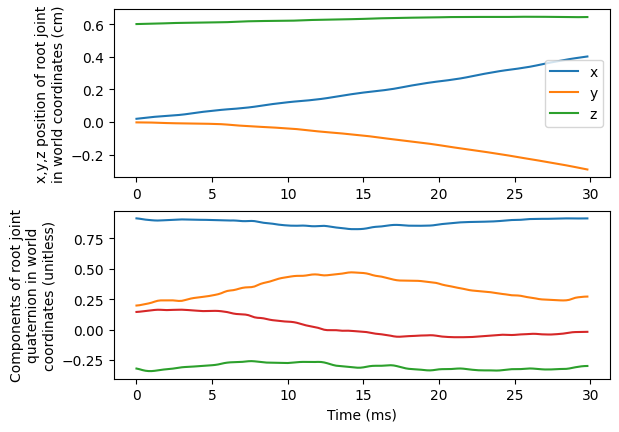

In [31]:
plt.subplot(2, 1, 1)
plt.plot(time_axis, root_qpos[:, :3], label=['x', 'y', 'z'])
plt.ylabel('x,y,z position of root joint\nin world coordinates (cm)')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(time_axis, root_qpos[:, 3:], label=['w', 'x', 'y', 'z'])
plt.xlabel('Time (ms)')
plt.ylabel('Components of root joint\nquaternion in world\ncoordinates (unitless)');